# Lab | Random Forests

For this lab, you will be using the .CSV files provided in the files_for_lab folder. These are cleaned versions of the learningSet data from the Case Study 'Healthcare for All'.
Begin a new Jupyter Notebook after Forking and Cloning this Repo.

Instructions

Apply the Random Forests algorithm but this time only by upscaling the data to deal with the imbalance.
Use Feature Selections that you have learned in class to decide if you want to use all of the features (Variance Threshold, RFE, PCA, etc.)

Re-run the Random Forest algorithm to determine if the Feature Selection has improved the results.
Discuss the output and its impact in the business scenario. Is the cost of a false positive equals to the cost of the false negative? How would you change your algorithm or data in order to maximize the return of the business?

In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split


numerical = pd.read_csv('numerical.csv')
categorical = pd.read_csv('categorical.csv')
targets = pd.read_csv('target.csv')
data = pd.concat([numerical, categorical, targets], axis = 1)
data['TARGET_B'].value_counts()

0    90569
1     4843
Name: TARGET_B, dtype: int64

In [2]:
data.isna().sum().sum()

0

In [3]:
y = data['TARGET_B']
X = data.drop(['TARGET_B'], axis = 1)

numericalX = X.select_dtypes(np.number)
categoricalX = X.select_dtypes(np.object)

# we OneHotEncode the categoricals so we can use the same dataset to perform a regression later (in the lab).
# it is not needed for a DecisionTree or RandomForest model-->no one hot encoding needed, but do for later
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(drop='first').fit(categoricalX)
encoded_categorical = encoder.transform(categoricalX).toarray()
encoded_categorical = pd.DataFrame(encoded_categorical)
X = pd.concat([numericalX, encoded_categorical], axis = 1)

# Note: we need to do train/test split before downsampling, and then only downsample the training set - Why?
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [4]:
trainset=pd.concat([y_train, X_train ], axis=1)

In [5]:
from sklearn.utils import resample

category_0 = trainset[trainset['TARGET_B'] == 0]
category_1 = trainset[trainset['TARGET_B'] == 1]

In [6]:
category_1_oversampled = resample(category_1, 
                                  replace=True, 
                                  n_samples = len(category_0))
print(category_0.shape)
print(category_1_oversampled.shape)

(72486, 356)
(72486, 356)


In [7]:
data_upsampled = pd.concat([category_0, category_1_oversampled], axis=0)

In [8]:
X_train_upsampled = data_upsampled.drop(columns=['TARGET_B'])
y_train_upsampled = data_upsampled['TARGET_B']

In [9]:
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)

y_train_regression = X_train['TARGET_D']
y_test_regression = X_test['TARGET_D']

# Now we can remove the column target d from the set of features
X_train = X_train.drop(['TARGET_D'], axis = 1)
X_test = X_test.drop(['TARGET_D'], axis = 1)

In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

clf = RandomForestClassifier(max_depth=5,
                             min_samples_split=20,
                             min_samples_leaf =20,
                             max_samples=0.8,
                             random_state = 42)
clf.fit(X_train, y_train)
print(clf.score(X_train, y_train))
print(clf.score(X_test, y_test))

y_pred = clf.predict(X_test)
display(y_test.value_counts())
display(confusion_matrix(y_test, y_pred))

0.9496521636599458
0.9475973379447676


0    18083
1     1000
Name: TARGET_B, dtype: int64

array([[18083,     0],
       [ 1000,     0]], dtype=int64)

In [11]:
# For cross validation
from sklearn.model_selection import cross_val_score
clf = RandomForestClassifier(max_depth=5,
                             min_samples_split=20,
                             min_samples_leaf =20)
cross_val_scores = cross_val_score(clf, X_train, y_train, cv=10)
print(np.mean(cross_val_scores))

0.9496521640971386


In [12]:
cross_val_scores

array([0.94969213, 0.94969213, 0.94969213, 0.94969213, 0.94969213,
       0.94969213, 0.94956112, 0.94956112, 0.94956112, 0.94968553])

In [13]:
from sklearn.feature_selection import VarianceThreshold, RFE
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
import statsmodels.api as sm
X_added_constant = sm.add_constant(X_train_upsampled)
X_added_constant
model = sm.OLS(y_train_upsampled,X_added_constant).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               TARGET_B   R-squared:                       0.596
Model:                            OLS   Adj. R-squared:                  0.595
Method:                 Least Squares   F-statistic:                     600.8
Date:                Thu, 06 Apr 2023   Prob (F-statistic):               0.00
Time:                        21:06:50   Log-Likelihood:                -39532.
No. Observations:              144972   AIC:                         7.978e+04
Df Residuals:                  144616   BIC:                         8.329e+04
Df Model:                         355                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -3.8772      0.334    -11.610      0.000      -4.532      -3.223
TCODE          2.44e-06   8.62e-07      2.832      0.005    7.51e-07    4.13e-06
AGE             -0.0009   7.77e-05    -11.236      0.000      -0.001      -0.001
INCOME           0.0031      0.001      4.997      0.000       0.002       0.004
WEALTH1         -0.0049      0.000    -11.746      0.000      -0.006      -0.004
HIT             -0.0002   9.42e-05     -2.250      0.024      -0.000   -2.73e-05
MALEMILI        -0.0011      0.000     -3.122      0.002      -0.002      -0.000
MALEVET         -0.0002      0.000     -1.229      0.219      -0.001       0.000
VIETVETS        -0.0004      0.000     -3.833      0.000      -0.001      -0.000
WWIIVETS         0.0002      0.000      2.177      0.030    2.41e-05       0.000
LOCALGOV      7.256e-05      0.000      0.188      0.851      -0.001       0.001
STATEGOV         0.0010      0.000      2.785      0.005       0.000       0.002
FEDGOV       -4.311e-05      0.001     -0.084      0.933      -0.001       0.001
WEALTH2         -0.0010      0.000     -2.581      0.010      -0.002      -0.000
POP901        1.981e-06   1.38e-06      1.431      0.152   -7.32e-07     4.7e-06
POP902       -2.288e-05   4.93e-06     -4.643      0.000   -3.25e-05   -1.32e-05
POP903        1.103e-05   2.51e-06      4.389      0.000     6.1e-06     1.6e-05
POP90C1          0.0024      0.002      1.201      0.230      -0.001       0.006
POP90C2          0.0022      0.002      1.112      0.266      -0.002       0.006
POP90C3          0.0020      0.002      1.029      0.304      -0.002       0.006
POP90C4          0.0773      0.026      3.011      0.003       0.027       0.128
POP90C5          0.0772      0.026      3.008      0.003       0.027       0.127
ETH1            -0.0196      0.001    -13.294      0.000      -0.022      -0.017
ETH2             0.0042      0.002      2.340      0.019       0.001       0.008
ETH3         -6.602e-05      0.000     -0.143      0.886      -0.001       0.001
ETH4            -0.0017      0.001     -1.693      0.090      -0.004       0.000
ETH5             0.0074      0.002      4.591      0.000       0.004       0.010
ETH6             0.0041      0.002      2.288      0.022       0.001       0.008
ETH7             0.0010      0.001      0.926      0.354      -0.001       0.003
ETH8            -0.0002      0.001     -0.155      0.877      -0.002       0.002
ETH9         -9.115e-05      0.001     -0.089      0.929      -0.002       0.002
ETH10           -0.0009      0.001     -0.690      0.490      -0.003       0.002
ETH11            0.0027      0.001      2.015      0.044    7.39e-05       0.005
ETH12            0.0028      0.001      2.097      0.036       0.000       0.005
ETH13           -0.0076      0.002     -4.735      0.000      -0.011      -0.004
ETH14

In [14]:
rfc = RandomForestClassifier(max_depth=5,
                             min_samples_split=20,
                             min_samples_leaf =20,
                             max_samples=0.2,
                             random_state = 42)
rfc.fit(X_train_upsampled, y_train_upsampled)
print(rfc.score(X_train_upsampled,y_train_upsampled))
print(rfc.score(X_test,y_test))
# Make predictions on the test data
y_pred = rfc.predict(X_test)

0.9994205777667412


ValueError: X has 354 features, but RandomForestClassifier is expecting 355 features as input.

# variance threshold

In [16]:
vt = VarianceThreshold(threshold=0.05)
X_vt = vt.fit_transform(X_train_upsampled)
scores_vt = cross_val_score(rfc, X_vt, y_train_upsampled, cv=5, scoring='accuracy')
scores_vt.mean()

0.9823622084109594

In [36]:
vt = VarianceThreshold(threshold=0.1)
X_vt = vt.fit_transform(X_train_upsampled)
scores_vt = cross_val_score(rfc, X_vt, y_train_upsampled, cv=5, scoring='accuracy')
scores_vt.mean()

0.9978616332046888

In [37]:
vt = VarianceThreshold(threshold=0.05)
X_vt = vt.fit_transform(X_train_upsampled)
scores_vt = cross_val_score(rfc, X_vt, y_train_upsampled, cv=10, scoring='accuracy')
scores_vt.mean()

0.985024620094217

# PCA

In [20]:
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_train_upsampled)
scores_pca = cross_val_score(rfc, X_pca, y_train_upsampled, cv=5, scoring='accuracy')
scores_pca.mean()

0.560218521881004

In [21]:
pca = PCA(n_components=5)
X_pca = pca.fit_transform(X_train_upsampled)
scores_pca = cross_val_score(rfc, X_pca, y_train_upsampled, cv=5, scoring='accuracy')
scores_pca.mean()

0.5671232802767061

In [22]:
pca = PCA(n_components=7)
X_pca = pca.fit_transform(X_train_upsampled)
scores_pca = cross_val_score(rfc, X_pca, y_train_upsampled, cv=5, scoring='accuracy')
scores_pca.mean()

0.5686063573957414

In [23]:
pca = PCA(n_components=9)
X_pca = pca.fit_transform(X_train_upsampled)
scores_pca = cross_val_score(rfc, X_pca, y_train_upsampled, cv=5, scoring='accuracy')
scores_pca.mean()

0.5752007445677703

In [24]:
pca = PCA(n_components=11)
X_pca = pca.fit_transform(X_train_upsampled)
scores_pca = cross_val_score(rfc, X_pca, y_train_upsampled, cv=5, scoring='accuracy')
scores_pca.mean()

0.5767044661397914

In [25]:
pca = PCA(n_components=13)
X_pca = pca.fit_transform(X_train_upsampled)
scores_pca = cross_val_score(rfc, X_pca, y_train_upsampled, cv=5, scoring='accuracy')
scores_pca.mean()

0.5768493251239415

In [26]:
pca = PCA(n_components=21)
X_pca = pca.fit_transform(X_train_upsampled)
scores_pca = cross_val_score(rfc, X_pca, y_train_upsampled, cv=5, scoring='accuracy')
scores_pca.mean()

0.5878169654904667

In [27]:
pca = PCA(n_components=51)
X_pca = pca.fit_transform(X_train_upsampled)
scores_pca = cross_val_score(rfc, X_pca, y_train_upsampled, cv=5, scoring='accuracy')
scores_pca.mean()

0.672647113019786

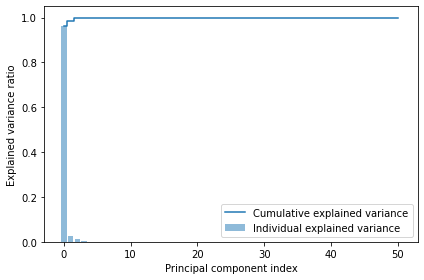

In [31]:
import matplotlib.pyplot as plt
exp_var_pca = pca.explained_variance_ratio_

# Cumulative sum of eigenvalues; This will be used to create step plot
# for visualizing the variance explained by each principal component.

cum_sum_eigenvalues = np.cumsum(exp_var_pca)
#cum_sum_eigenvalues

# Create the visualization plot
plt.bar(range(0,len(exp_var_pca)), exp_var_pca, 
        alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, 
         where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [33]:
pca = PCA(n_components=1)
X_pca = pca.fit_transform(X_train_upsampled)
scores_pca = cross_val_score(rfc, X_pca, y_train_upsampled, cv=5, scoring='accuracy')
scores_pca.mean()

0.547009062402657

In [34]:
pca = PCA(n_components=175)
X_pca = pca.fit_transform(X_train_upsampled)
scores_pca = cross_val_score(rfc, X_pca, y_train_upsampled, cv=5, scoring='accuracy')
scores_pca.mean()

0.9243647110724028

In [35]:
pca = PCA(n_components=354)
X_pca = pca.fit_transform(X_train_upsampled)
scores_pca = cross_val_score(rfc, X_pca, y_train_upsampled, cv=5, scoring='accuracy')
scores_pca.mean()

0.9150801432976309

# X and y upsampled

In [19]:
scores_ups = cross_val_score(rfc, X_train_upsampled, y_train_upsampled, cv=5, scoring='accuracy')
scores_ups.mean()

0.9974270583933601

In [28]:
from sklearn.tree import DecisionTreeRegressor
regr = DecisionTreeRegressor(max_depth=4)
regr.fit(X_train, y_train)
print("test data score was: ",regr.score(X_test, y_test))
print("train data score was: ",regr.score(X_train, y_train))

test data score was:  0.00234803942425732
train data score was:  0.012581801350969646


In [29]:
max_depth = range(1,30)
test = []
train = []

for depth in max_depth:
    model = DecisionTreeRegressor(max_depth=depth, random_state=0)
    model.fit(X_train, y_train)
    test.append(model.score(X_test,y_test))
    train.append(model.score(X_train,y_train))

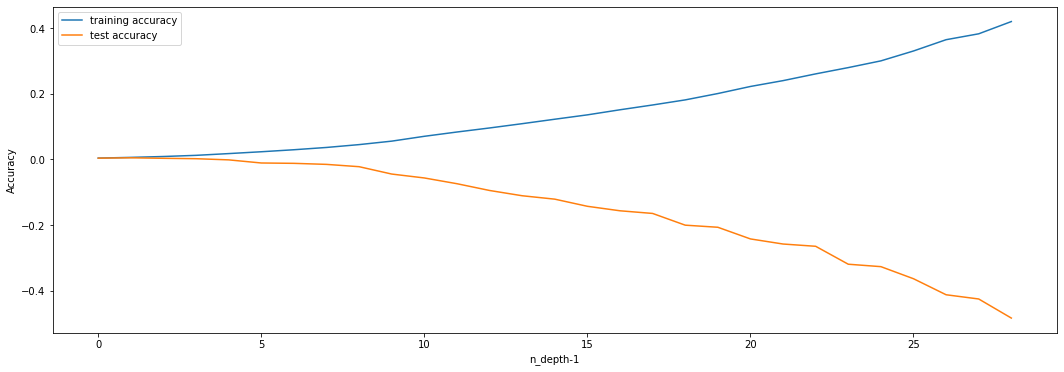

In [32]:
# we quickly see overfitting properties
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(18,6))
plt.plot( train, label="training accuracy")
plt.plot( test, label="test accuracy")
plt.ylabel("Accuracy")
plt.xlabel("n_depth-1")
plt.legend()

In [ ]:
# not much space for improfment...having more features is better